In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tgt
from IPython.display import Audio, display
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram
from torchcodec.decoders import AudioDecoder

from zerosyl.model import ZeroSylDiscrete, ZeroSylDiscreteCollapsed

In [2]:
# Get all the waveform and alignment paths

waveform_dir = Path.cwd() / "data/waveforms/LibriSpeech/dev-clean"
alignment_dir = Path.cwd() / "data/alignments/LibriSpeech/dev-clean"

waveform_paths = {p.stem: p for p in waveform_dir.rglob("*.flac")}
alignment_paths = {p.stem: p for p in alignment_dir.rglob("*.TextGrid")}

common_stems = sorted(waveform_paths.keys() & alignment_paths.keys())
waveform_paths = [waveform_paths[s] for s in common_stems]
alignment_paths = [alignment_paths[s] for s in common_stems]


In [3]:
# Process a random example

index = np.random.randint(len(waveform_paths))
waveform_path = waveform_paths[index]
alignment_path = alignment_paths[index]

tg = tgt.read_textgrid(alignment_path, include_empty_intervals=False)
words = [interval.text for interval in tg.get_tier_by_name("words")]
print(f"Processing {waveform_path.name}, {" ".join(words)}")

Processing 251-137823-0020.flac, the two girls were as much upset as tom's mother tom laughed


In [4]:
# Functions for plotting

def plot_boundaries(melspec, textgrid, tokens, starts, ends):
    plt.figure(figsize=(12, 6), constrained_layout=True)
    plt.subplot(2, 1, 1)
    plt.imshow(melspec, aspect="auto", origin="lower")
    xticks = []
    xtickslabels = []
    for interval in textgrid.get_tier_by_name("syllables"):
        x1 = interval.start_time * 50
        x2 = interval.end_time * 50
        xticks.append((x1 + x2) / 2)
        xtickslabels.append(interval.text)
        plt.axvline(x1, color="white")
        plt.axvline(x2, color="white")
    plt.xticks(xticks, xtickslabels, rotation=90)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_label_position("top")
    plt.title("Syllables from forced alignments")
    plt.xlim(0, textgrid.end_time * 50)
    plt.subplot(2, 1, 2)
    plt.imshow(melspec, aspect="auto", origin="lower")
    xticks = []
    xtickslabels = []
    for token, start, end in zip(tokens, starts, ends):
        x1 = start.item()
        x2 = end.item()
        xticks.append((x1 + x2) / 2)
        xtickslabels.append(str(token.item()))
        plt.axvline(x1, color="white")
        plt.axvline(x2, color="white")
    plt.xticks(xticks, xtickslabels, rotation=90)
    plt.gca().get_yaxis().set_visible(False)
    plt.title("ZeroSyl-Discrete boundaries and tokens")
    plt.xlim(0, textgrid.end_time * 50)
    plt.show()


In [5]:
textgrid = tgt.read_textgrid(alignment_path, include_empty_intervals=False)

decoder = AudioDecoder(waveform_path, sample_rate=16000, num_channels=1)
audio = decoder.get_all_samples()
wav = audio.data.cuda()

tMelSpectrogram = MelSpectrogram(16000, 1024, 400, 320, n_mels=100)
tAmplitudeToDB = AmplitudeToDB(top_db=80)

melspec = tAmplitudeToDB(tMelSpectrogram(audio.data))[0]

display(Audio(waveform_path))

transcription = " ".join([interval.text for interval in textgrid.get_tier_by_name("words")])
print(f"Transcription: {transcription}")

Transcription: the two girls were as much upset as tom's mother tom laughed


## Model without collapsing silences

In [6]:
if "model" not in locals():
    model = ZeroSylDiscrete.from_pretrained_checkpoint(
        checkpoint_path="checkpoints/WavLM-Large.pt",
        centroids_path="checkpoints/km10000-centroids-v040.pt"
    ).cuda()

/home/nicolvisser/.cache/pypoetry/virtualenvs/zerosyl-Suft6ghr-py3.12/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


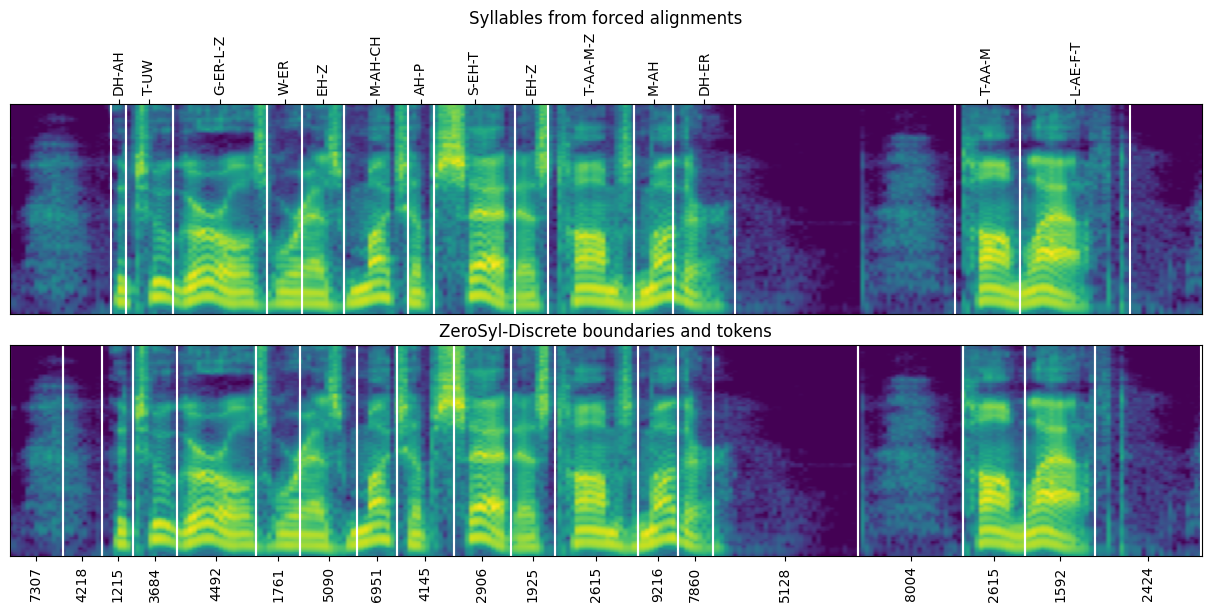

In [7]:
tokens, starts, ends = model.tokenize(wav)
plot_boundaries(melspec, textgrid, tokens, starts, ends)

## Model with silences collapsed

In [8]:
if "model_with_collapsing" not in locals():
    model_with_collapsing = ZeroSylDiscreteCollapsed.from_pretrained_checkpoint(
        checkpoint_path="checkpoints/WavLM-Large.pt",
        centroids_path="checkpoints/km10000-centroids-v040.pt",
        silences_path="checkpoints/km10000-silences-v040.pt"
    ).cuda()

/home/nicolvisser/.cache/pypoetry/virtualenvs/zerosyl-Suft6ghr-py3.12/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


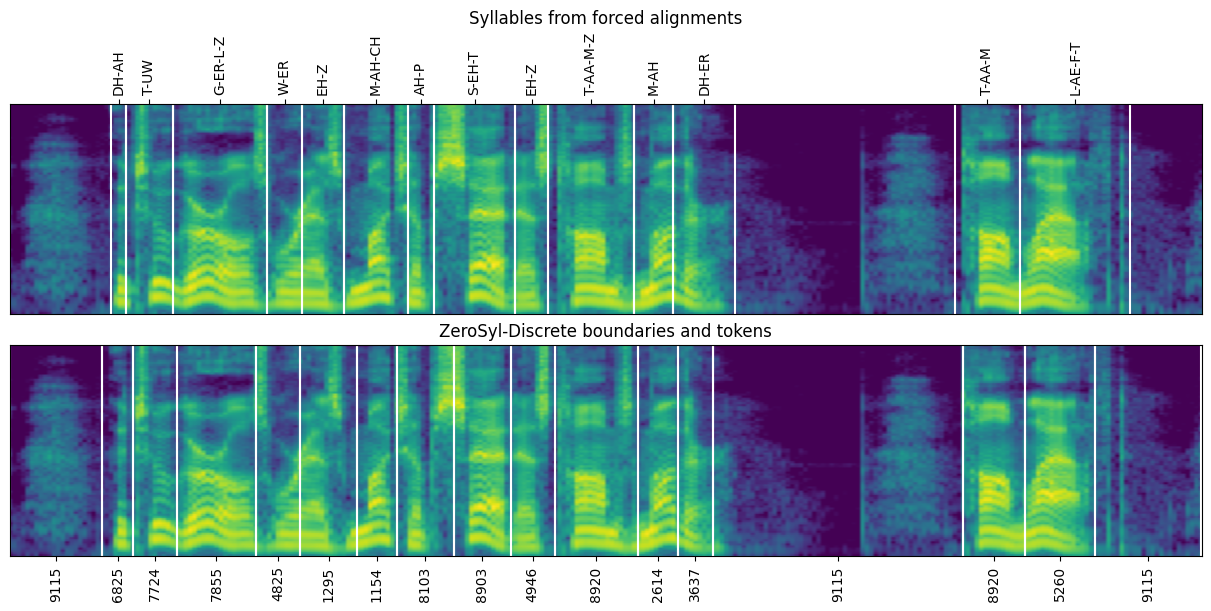

In [9]:
tokens, starts, ends = model_with_collapsing.tokenize(wav)
plot_boundaries(melspec, textgrid, tokens, starts, ends)